# Final project.


## Frame definition

Stationary frame is the space frame (world) {s}

Geometric center of the box is marked as box frame {b}

Geometric center of the dice is marked as dice frame {d}


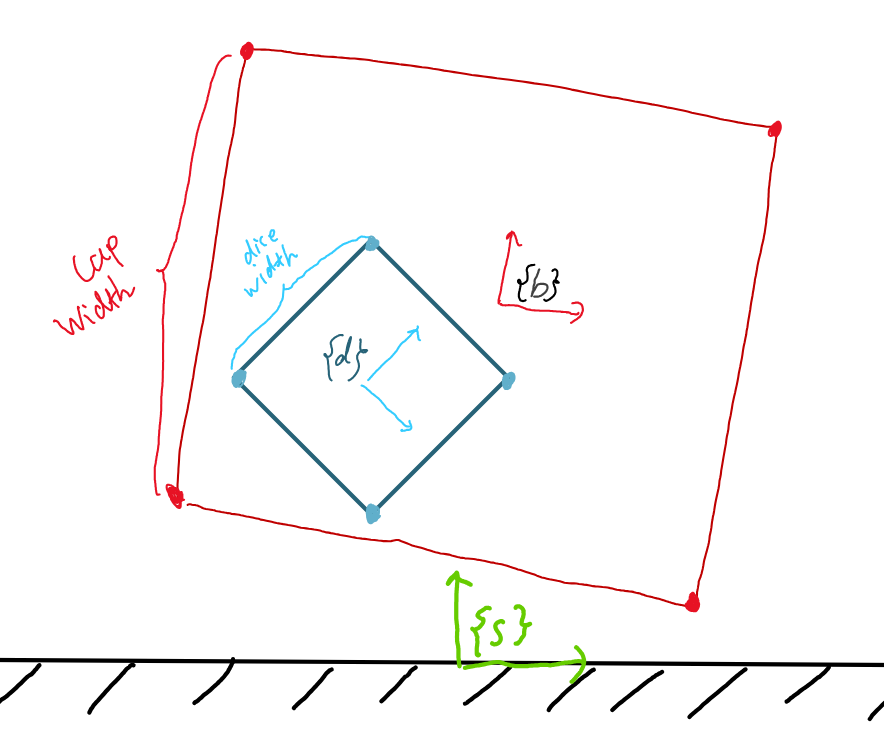

The position of box is defined by it's x,y and theta in space frame. 

The position of dice is defined by it's x,y and theta in the box frame.

Both the x,y,theta in box and dice defines the offset between their frames. Thus the initial position must take into account of the dimension of box and dice so it doesn't start in collision.  

At rest, all three frames are lined up at the same orientation, and alined on Y axis.


The box and dice are both square and defined by a width value.

Both box and dice have mass and inertia



In [1]:
#IMPORT ALL NECESSARY PACKAGES AT THE TOP OF THE CODE
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
import dataclasses # used to group variables 

# Custom display helpers
from IPython.display import Markdown

def md_print(md_str: str):
    display(Markdown(md_str))

def lax_eq(equation):
    return sym.latex(equation , mode='inline')



import sympy as sym
def get_eu_la(L: sym.Function, q: sym.Matrix, t: sym.symbols):
    """Generate euler lagrangian using sympy jacobian

    Args:
        L (sym.Function): Lagrangian equation
        q (sym.Matrix): matrix of system-var q
        t (sym.symbols): time symbol (needed for q.diff(t))
    """

    q_dot = q.diff(t)
    dL_dq = sym.simplify(sym.Matrix([L]).jacobian(q).T)
    dL_dq_dot = sym.simplify(sym.Matrix([L]).jacobian(q_dot).T)

    return sym.simplify(dL_dq_dot.diff(t) - dL_dq)


def solve_and_print(variables: sym.Matrix,
                    eu_la_eq: sym.Eq , quiet = False) -> list[dict[any]]:
    """Solve the given eu_la equation  

    Args:
        variables (sym.Matrix): var to solve for
        eu_la_eq (sym.Eq): eu_la equation
        quiet (bool): turn off any printing if True

    Returns:
        list[dict[sym.Function]]: list of solution dicts (keyed with variables)
    """
    solution_dicts = sym.solve(eu_la_eq, variables, dict=True)
    i = 0
    print(f"Total of {len(solution_dicts)} solutions")
    for solution_dict in solution_dicts:
        i += 1
        if not quiet: md_print(f"solution : {i} / {len(solution_dicts)}")
        for var in variables:
            sol = solution_dict[var]
            if not quiet: md_print(f"{lax_eq(var)} = {lax_eq(sol.expand())}")
    return solution_dicts

def lambdify_sys(var_list: list, function_dict: dict[any, sym.Function], keys =None):
    lambda_dict ={}
    if keys is None:
        keys = function_dict.keys()
    for var in keys:
        acceleration_function = (function_dict[var])
        lambda_func = sym.lambdify(var_list, acceleration_function )
        lambda_dict[var] = lambda_func
    return lambda_dict

def make_system_equation(lambda_dict,lam_keys):
    '''
    '''
    # def system_equation(state , lambda_dict ,lam_keys , optional_args = None ):
    def system_equation(state , optional_args = None ):
        state = state.tolist()
        accel_list = []
        # print(optional_args)
        # print(lambda_input)
        for key in lam_keys:
            if optional_args is not None:
                accel_list.append(lambda_dict[key](*state , optional_args) )
            else:
                try:
                    accel_list.append(lambda_dict[key](*state) )
                except Exception as e :
                    print(state)
                    display(key)
                    print(e)

        
        velocity_list = state[int (len(state)/2): :]
        out_list = velocity_list + accel_list
        return np.array(out_list) 
    # return lambda state , optional_args = None: system_equation(state , lambda_dict , lam_keys , optional_args)
    return system_equation


def integrate(f, xt, dt):
    """
    This function takes in an initial condition x(t) and a timestep dt,
    as well as a dynamical system f(x) that outputs a vector of the
    same dimension as x(t). It outputs a vector x(t+dt) at the future
    time step.

    Parameters
    ============
    dyn: Python function
        derivate of the system at a given step x(t),
        it can considered as \dot{x}(t) = func(x(t))
    xt: NumPy array
        current step x(t)
    dt:
        step size for integration

    Return
    ============
    new_xt:
        value of x(t+dt) integrated from x(t)
    """
    k1 = dt * f(xt)
    k2 = dt * f(xt+k1/2.)
    k3 = dt * f(xt+k2/2.)
    k4 = dt * f(xt+k3)

    new_xt = xt + (1/6.) * (k1+2.0*k2+2.0*k3+k4)
    return new_xt

In [2]:
# Transformation helpers 

def rotz(theta):
    return sym.Matrix([[sym.cos(theta) , -sym.sin(theta) ,0 ,0 ],
                        [sym.sin(theta) , sym.cos(theta) ,0 ,0 ],
                        [ 0            , 0               ,1 ,0 ],
                        [0             ,0                ,0 ,1 ]])

def trans(x=0,y=0,z=0):
    return sym.Matrix([
        [1,0,0,x],
        [0,1,0,y],
        [0,0,1,0],
        [0,0,0,1]
])

def get_x_y(T):
    return T[0,3] , T[1,3]

# The same as Unhat but omega then v 
# se3 is T-1 @ T_dot
def se3ToVec(se3mat):
    """ Converts an se3 matrix into a spatial velocity vector

    :param se3mat: A 4x4 matrix in se3
    :return: The spatial velocity 6-vector corresponding to se3mat

    Example Input:
        se3mat = np.array([[ 0, -3,  2, 4],
                           [ 3,  0, -1, 5],
                           [-2,  1,  0, 6],
                           [ 0,  0,  0, 0]])
    Output:
        np.array([1, 2, 3, 4, 5, 6])
    """
    return sym.Matrix([se3mat[2,1] , se3mat[0,2] ,se3mat[1,0] ,
    se3mat[0,3], se3mat[1,3], se3mat[2,3]
    ])

def TransToRp(T):
    """Converts a homogeneous transformation matrix into a rotation matrix
    and position vector

    :param T: A homogeneous transformation matrix
    :return R: The corresponding rotation matrix,
    :return p: The corresponding position vector.

    Example Input:
        T = np.array([[1, 0,  0, 0],
                      [0, 0, -1, 0],
                      [0, 1,  0, 3],
                      [0, 0,  0, 1]])
    Output:
        (np.array([[1, 0,  0],
                   [0, 0, -1],
                   [0, 1,  0]]),
         np.array([0, 0, 3]))
    """
    return T[0: 3, 0: 3], T[0: 3, 3]

def TransInv(T):
    """Inverts a homogeneous transformation matrix

    :param T: A homogeneous transformation matrix
    :return: The inverse of T
    Uses the structure of transformation matrices to avoid taking a matrix
    inverse, for efficiency.

    Example input:
        T = np.array([[1, 0,  0, 0],
                      [0, 0, -1, 0],
                      [0, 1,  0, 3],
                      [0, 0,  0, 1]])
    Output:
        np.array([[1,  0, 0,  0],
                  [0,  0, 1, -3],
                  [0, -1, 0,  0],
                  [0,  0, 0,  1]])
    """
    R, p = TransToRp(T)
    Rt = R.T

    return sym.Matrix([
        [Rt , - Rt @ p],
        [sym.zeros(1,3) ,sym.ones(1)] 
    ])


In [3]:
# Defining symbols and the system equations

box_width = 2
dice_width = 0.4
g = 9.8
# g = 1 # smaller G to make simulation looks better
# Assume simple mass and interia

mass_box = 5
mass_dice = 0.2

inertia_box = 1
inertia_dice = 0.02

box_z_rot_force = 3

t= sym.symbols('t')

box_x = sym.Function(r'x_{box}')(t)
box_y = sym.Function(r'y_{box}')(t)
box_theta = sym.Function(r'\theta_{box}')(t)

# relateive to box
dice_x = sym.Function(r'x_{dice}')(t)
dice_y = sym.Function(r'y_{dice}')(t)
dice_theta = sym.Function(r'\theta_{dice}')(t)

# The system variable
q = sym.Matrix([
    box_x,
    box_y,
    box_theta,
    dice_x,
    dice_y,
    dice_theta,
])

q_dot = q.diff(t)
q_ddot = q_dot.diff(t)


# Define the transformation between three frames
Tsb = trans(box_x , box_y) @ rotz(box_theta)
Tbd = trans(dice_x , dice_y) @ rotz(dice_theta)

Tsd = Tsb @ Tbd

md_print(f"Frame Tsb \n{lax_eq(Tsb)}")
md_print(f"Frame Tbd \n{lax_eq(Tbd)}")
md_print(f"Frame Tsd \n{lax_eq(Tsd)}")

# four corner of the dice.
# We mark 4 corners as 1,2,3,4,
# define with 4 homogenous vector P_d [x,y,z,1] (in dice frame)
#  for easily used with Transform matrix
corner_P_d_map = {
    "Dice-upper-right": [dice_width/2 , dice_width/2 ,0 ,1],  # upper right
    "Dice-upper-left": [-dice_width/2 , dice_width/2 ,0 ,1], # upper left 
    "Dice-lower-right": [dice_width/2 , -dice_width/2 ,0 ,1], # lower right
    "Dice-lower-left": [-dice_width/2 , -dice_width/2 ,0 ,1], # lower left
}

box_corner_P_b_map = {
    "Box-upper-right": [box_width/2 , box_width/2 ,0 ,1],  # upper right
    "Box-upper-left": [-box_width/2 , box_width/2 ,0 ,1], # upper left 
    "Box-lower-right": [box_width/2 , -box_width/2 ,0 ,1], # lower right
    "Box-lower-left": [-box_width/2 , -box_width/2 ,0 ,1], # lower left
}
print(corner_P_d_map)
# Convert the corner P into box frame
corner_P_b_map = {}
for name,P_d in corner_P_d_map.items():
    P_b = Tbd @ sym.Matrix( P_d)
    # display(name)
    # display(P_b)
    corner_P_b_map[name] = P_b

print("Dice corner in box frame {b}")
display(corner_P_b_map)

V_b = se3ToVec(TransInv(Tsb) @ (Tsb.diff(t)) )
V_d = se3ToVec(TransInv(Tsd) @ (Tsd.diff(t)) )

I_box_6 = sym.Matrix([[mass_box, 0, 0, 0, 0, 0],
                [0, mass_box, 0, 0, 0, 0],
                [0, 0, mass_box, 0, 0, 0],
                [0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, inertia_box]])
I_dice_6 = sym.Matrix([[mass_dice, 0, 0, 0, 0, 0],
                 [0, mass_dice, 0, 0, 0, 0],
                 [0, 0, mass_dice, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, inertia_dice]])

# Since using sym.Matrix, need to un-container it
KE_box = (0.5 * (V_b.T @ I_box_6 @ V_b) )[0]
KE_dice = (0.5 * (V_d.T @ I_dice_6 @ V_d) )[0]

PE_box = get_x_y(Tsb)[1] * mass_box *g
PE_dice = get_x_y(Tsd)[1] * mass_dice *g
L = (KE_box + KE_dice - PE_box - PE_dice).simplify()
eu_la = get_eu_la(L, q, t)
md_print(f"eu_la equation = \n{lax_eq(eu_la)}")

Frame Tsb 
$\left[\begin{smallmatrix}\cos{\left(\theta_{box}{\left(t \right)} \right)} & - \sin{\left(\theta_{box}{\left(t \right)} \right)} & 0 & \operatorname{x_{box}}{\left(t \right)}\\\sin{\left(\theta_{box}{\left(t \right)} \right)} & \cos{\left(\theta_{box}{\left(t \right)} \right)} & 0 & \operatorname{y_{box}}{\left(t \right)}\\0 & 0 & 1 & 0\\0 & 0 & 0 & 1\end{smallmatrix}\right]$

Frame Tbd 
$\left[\begin{smallmatrix}\cos{\left(\theta_{dice}{\left(t \right)} \right)} & - \sin{\left(\theta_{dice}{\left(t \right)} \right)} & 0 & \operatorname{x_{dice}}{\left(t \right)}\\\sin{\left(\theta_{dice}{\left(t \right)} \right)} & \cos{\left(\theta_{dice}{\left(t \right)} \right)} & 0 & \operatorname{y_{dice}}{\left(t \right)}\\0 & 0 & 1 & 0\\0 & 0 & 0 & 1\end{smallmatrix}\right]$

Frame Tsd 
$\left[\begin{smallmatrix}- \sin{\left(\theta_{box}{\left(t \right)} \right)} \sin{\left(\theta_{dice}{\left(t \right)} \right)} + \cos{\left(\theta_{box}{\left(t \right)} \right)} \cos{\left(\theta_{dice}{\left(t \right)} \right)} & - \sin{\left(\theta_{box}{\left(t \right)} \right)} \cos{\left(\theta_{dice}{\left(t \right)} \right)} - \sin{\left(\theta_{dice}{\left(t \right)} \right)} \cos{\left(\theta_{box}{\left(t \right)} \right)} & 0 & \operatorname{x_{box}}{\left(t \right)} + \operatorname{x_{dice}}{\left(t \right)} \cos{\left(\theta_{box}{\left(t \right)} \right)} - \operatorname{y_{dice}}{\left(t \right)} \sin{\left(\theta_{box}{\left(t \right)} \right)}\\\sin{\left(\theta_{box}{\left(t \right)} \right)} \cos{\left(\theta_{dice}{\left(t \right)} \right)} + \sin{\left(\theta_{dice}{\left(t \right)} \right)} \cos{\left(\theta_{box}{\left(t \right)} \right)} & - \sin{\left(\theta_{box}{\left(t \right)} \right)} \sin{\left(\theta_{dice}{\left(t \right)} \right)} + \cos{\left(\theta_{box}{\left(t \right)} \right)} \cos{\left(\theta_{dice}{\left(t \right)} \right)} & 0 & \operatorname{x_{dice}}{\left(t \right)} \sin{\left(\theta_{box}{\left(t \right)} \right)} + \operatorname{y_{box}}{\left(t \right)} + \operatorname{y_{dice}}{\left(t \right)} \cos{\left(\theta_{box}{\left(t \right)} \right)}\\0 & 0 & 1 & 0\\0 & 0 & 0 & 1\end{smallmatrix}\right]$

{'Dice-upper-right': [0.2, 0.2, 0, 1], 'Dice-upper-left': [-0.2, 0.2, 0, 1], 'Dice-lower-right': [0.2, -0.2, 0, 1], 'Dice-lower-left': [-0.2, -0.2, 0, 1]}
Dice corner in box frame {b}


{'Dice-upper-right': Matrix([
 [x_{dice}(t) - 0.2*sin(\theta_{dice}(t)) + 0.2*cos(\theta_{dice}(t))],
 [y_{dice}(t) + 0.2*sin(\theta_{dice}(t)) + 0.2*cos(\theta_{dice}(t))],
 [                                                                  0],
 [                                                                  1]]),
 'Dice-upper-left': Matrix([
 [x_{dice}(t) - 0.2*sin(\theta_{dice}(t)) - 0.2*cos(\theta_{dice}(t))],
 [y_{dice}(t) - 0.2*sin(\theta_{dice}(t)) + 0.2*cos(\theta_{dice}(t))],
 [                                                                  0],
 [                                                                  1]]),
 'Dice-lower-right': Matrix([
 [x_{dice}(t) + 0.2*sin(\theta_{dice}(t)) + 0.2*cos(\theta_{dice}(t))],
 [y_{dice}(t) + 0.2*sin(\theta_{dice}(t)) - 0.2*cos(\theta_{dice}(t))],
 [                                                                  0],
 [                                                                  1]]),
 'Dice-lower-left': Matrix([
 [x_{dice}(t

eu_la equation = 
$\left[\begin{smallmatrix}- 1.0 \operatorname{x_{dice}}{\left(t \right)} \sin{\left(\theta_{box}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \theta_{box}{\left(t \right)} - 1.0 \operatorname{x_{dice}}{\left(t \right)} \cos{\left(\theta_{box}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{box}{\left(t \right)}\right)^{2} + 1.0 \operatorname{y_{dice}}{\left(t \right)} \sin{\left(\theta_{box}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{box}{\left(t \right)}\right)^{2} - 1.0 \operatorname{y_{dice}}{\left(t \right)} \cos{\left(\theta_{box}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \theta_{box}{\left(t \right)} - 2.0 \sin{\left(\theta_{box}{\left(t \right)} \right)} \frac{d}{d t} \theta_{box}{\left(t \right)} \frac{d}{d t} \operatorname{x_{dice}}{\left(t \right)} - 1.0 \sin{\left(\theta_{box}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \operatorname{y_{dice}}{\left(t \right)} - 2.0 \cos{\left(\theta_{box}{\left(t \right)} \right)} \frac{d}{d t} \theta_{box}{\left(t \right)} \frac{d}{d t} \operatorname{y_{dice}}{\left(t \right)} + 1.0 \cos{\left(\theta_{box}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \operatorname{x_{dice}}{\left(t \right)} + 2.0 \frac{d^{2}}{d t^{2}} \operatorname{x_{box}}{\left(t \right)}\\- 1.0 \operatorname{x_{dice}}{\left(t \right)} \sin{\left(\theta_{box}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{box}{\left(t \right)}\right)^{2} + 1.0 \operatorname{x_{dice}}{\left(t \right)} \cos{\left(\theta_{box}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \theta_{box}{\left(t \right)} - 1.0 \operatorname{y_{dice}}{\left(t \right)} \sin{\left(\theta_{box}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \theta_{box}{\left(t \right)} - 1.0 \operatorname{y_{dice}}{\left(t \right)} \cos{\left(\theta_{box}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{box}{\left(t \right)}\right)^{2} - 2.0 \sin{\left(\theta_{box}{\left(t \right)} \right)} \frac{d}{d t} \theta_{box}{\left(t \right)} \frac{d}{d t} \operatorname{y_{dice}}{\left(t \right)} + 1.0 \sin{\left(\theta_{box}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \operatorname{x_{dice}}{\left(t \right)} + 2.0 \cos{\left(\theta_{box}{\left(t \right)} \right)} \frac{d}{d t} \theta_{box}{\left(t \right)} \frac{d}{d t} \operatorname{x_{dice}}{\left(t \right)} + 1.0 \cos{\left(\theta_{box}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \operatorname{y_{dice}}{\left(t \right)} + 2.0 \frac{d^{2}}{d t^{2}} \operatorname{y_{box}}{\left(t \right)} + 53.9\\1.0 \operatorname{x_{dice}}^{2}{\left(t \right)} \frac{d^{2}}{d t^{2}} \theta_{box}{\left(t \right)} - 1.0 \operatorname{x_{dice}}{\left(t \right)} \sin{\left(\theta_{box}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \operatorname{x_{box}}{\left(t \right)} + 1.0 \operatorname{x_{dice}}{\left(t \right)} \cos{\left(\theta_{box}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \operatorname{y_{box}}{\left(t \right)} + 4.9 \operatorname{x_{dice}}{\left(t \right)} \cos{\left(\theta_{box}{\left(t \right)} \right)} + 2.0 \operatorname{x_{dice}}{\left(t \right)} \frac{d}{d t} \theta_{box}{\left(t \right)} \frac{d}{d t} \operatorname{x_{dice}}{\left(t \right)} + 1.0 \operatorname{x_{dice}}{\left(t \right)} \frac{d^{2}}{d t^{2}} \operatorname{y_{dice}}{\left(t \right)} + 1.0 \operatorname{y_{dice}}^{2}{\left(t \right)} \frac{d^{2}}{d t^{2}} \theta_{box}{\left(t \right)} - 1.0 \operatorname{y_{dice}}{\left(t \right)} \sin{\left(\theta_{box}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \operatorname{y_{box}}{\left(t \right)} - 4.9 \operatorname{y_{dice}}{\left(t \right)} \sin{\left(\theta_{box}{\left(t \right)} \right)} - 1.0 \operatorname{y_{dice}}{\left(t \right)} \cos{\left(\theta_{box}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \operatorname{x_{box}}{\left(t \right)} + 2.0 \operatorname{y_{dice}}{\left(t \right)} \frac{d}{d t} \theta_{box}{\left(t \right)} \frac{d}{d t} \operatorname{y_{dice}}{\left(t \right)} - 1.0 \operatorname{y_{dice}}{\left(t \right)} \frac{d^{2}}{d t^{2}} \operatorname{x_{dice}}{\left(t \right)} + 5.5 \frac{d^{2}}{d t^{2}} \theta_{box}{\left(t \right)} + 0.5 \frac{d^{2}}{d t^{2}} \theta_{dice}{\left(t \right)}\\- 1.0 \operatorname{x_{dice}}{\left(t \right)} \left(\frac{d}{d t} \theta_{box}{\left(t \right)}\right)^{2} - 1.0 \operatorname{y_{dice}}{\left(t \right)} \frac{d^{2}}{d t^{2}} \theta_{box}{\left(t \right)} + 1.0 \sin{\left(\theta_{box}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \operatorname{y_{box}}{\left(t \right)} + 4.9 \sin{\left(\theta_{box}{\left(t \right)} \right)} + 1.0 \cos{\left(\theta_{box}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \operatorname{x_{box}}{\left(t \right)} - 2.0 \frac{d}{d t} \theta_{box}{\left(t \right)} \frac{d}{d t} \operatorname{y_{dice}}{\left(t \right)} + 1.0 \frac{d^{2}}{d t^{2}} \operatorname{x_{dice}}{\left(t \right)}\\1.0 \operatorname{x_{dice}}{\left(t \right)} \frac{d^{2}}{d t^{2}} \theta_{box}{\left(t \right)} - 1.0 \operatorname{y_{dice}}{\left(t \right)} \left(\frac{d}{d t} \theta_{box}{\left(t \right)}\right)^{2} - 1.0 \sin{\left(\theta_{box}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \operatorname{x_{box}}{\left(t \right)} + 1.0 \cos{\left(\theta_{box}{\left(t \right)} \right)} \frac{d^{2}}{d t^{2}} \operatorname{y_{box}}{\left(t \right)} + 4.9 \cos{\left(\theta_{box}{\left(t \right)} \right)} + 2.0 \frac{d}{d t} \theta_{box}{\left(t \right)} \frac{d}{d t} \operatorname{x_{dice}}{\left(t \right)} + 1.0 \frac{d^{2}}{d t^{2}} \operatorname{y_{dice}}{\left(t \right)}\\0.5 \frac{d^{2}}{d t^{2}} \theta_{box}{\left(t \right)} + 0.5 \frac{d^{2}}{d t^{2}} \theta_{dice}{\left(t \right)}\end{smallmatrix}\right]$

In [4]:
# Do the normal eu_la solving

force_side = sym.Matrix([0]*len(eu_la))
force_side[2] = box_z_rot_force # Give a constant torque on the outter box
eu_la_eq= sym.Eq(eu_la , force_side )
eu_la_solution = solve_and_print(q_ddot, eu_la_eq , quiet =True)[0]



Total of 1 solutions


In [5]:
system_lamb_dict = lambdify_sys([*q,*q_dot] , eu_la_solution , q_ddot)
dyn_system_eq = make_system_equation(system_lamb_dict, q_ddot)


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
# Work on impact stuff

# Setup dummy variables for the velocity after impact
from typing import Any, Callable

q_dot_dummy_plus = []
for var in q:
    # Using q for looping for ease of names.
    # Since dummy is just used as a symbol
    name = repr(var).split("(")[0]
    base, sub = name.split("_")
    new_var = sym.symbols(r"\dot"
                          f"{{{name}}}^+")
    # display(new_var)
    q_dot_dummy_plus.append(new_var)
subs_q_dot_plus = {}
for var, var_dummy in zip(q_dot, q_dot_dummy_plus):
    subs_q_dot_plus[var] = var_dummy


def gen_phi_with_four_walls(p_b):
    return {
        # x bigger then right box wall
        "box-right": (box_width / 2) - p_b[0],
        # x smaller then left box wall
        "box-left":  (box_width/2) + p_b[0],
        # y bigger then top box wall
        "box-top":  (box_width/2) - p_b[1],
        # y smaller then btm box wall
        "box-btm":
             + (box_width / 2) + p_b[1]
    }


# Construct impact system for one phi

# Since the minus ver of the equation is before impact, it's just the same as normal.
# For simplicity, not created here.


@dataclasses.dataclass
class ImpactSystem():
    name: float
    # These are system symbols needed
    q: list[sym.Symbol]
    q_dot: list[sym.Symbol]
    q_dot_plus: list[sym.Symbol]


    lamb: sym.Symbol
    impact_equation: sym.Eq
    phi_lamb: sym.Function

    p_b : list[float]
    phi_eq: sym.Function

    # def __post_init__(self):
    #     self.phi_lambda =

    def get_phi_value(self, states: list[float]) -> float:
        if len(states) !=12:
            print("bug")
            print(states)
            print(len(states))
        return self.phi_lamb(*states[0:int(len(states) / 2)])

    def check_for_impact(self, states: list[float], init_phi_value: float) -> bool:
        current_phi =self.get_phi_value(states)

        # We check for both tolerance and sign change. 
        if abs(current_phi) < 0.01:
            return True
        # Sign change ensure still have impact after flying over.
        return self.get_phi_value(states) * init_phi_value < 0

    def impact_update_fun(self, states: list[float]) -> list[float]:
        # display(self.impact_equation)
        # return

        # states are 12 var with 6 for q, 6 for q dot
        input_q_val = states[0:int(len(states) / 2)]
        # input_qdot_val = states[int(len(states) / 2)::]

        # This pairs the input with the q and qdot variable into dict {sym:value}
        var_solve_for = [self.lamb] + self.q_dot_plus

        # q is a sym.Matrix, colum. Thus becomes list of list, no good one step method
        # state_value_dict = {}
        # for var, value in zip(self.q, input_q_val):
        #     state_value_dict[var] = value
        # for var, value in zip(self.q_dot, input_qdot_val):
        #     state_value_dict[var] = value

        state_value_dict = dict(zip( [*self.q,*self.q_dot] , states))
        # display(state_value_dict)
        impact_eq_num = self.impact_equation.subs(state_value_dict).simplify()

        # md_print(f"solving impact with {lax_eq(self.lamb)}")
        # Given q, qdot, solve for qdot+ and lambda
        solutions = sym.solve(impact_eq_num, var_solve_for, dict=True)

        # print(f"Found {len(solutions)} solutions")
        if not solutions:
            raise RuntimeError(f"Did not got any solution for {impact_pair_name} ")
        best_sol = solutions[0]
        best_lamb = abs(best_sol[self.lamb])
        for sol in solutions:
            if abs(sol[self.lamb]) > best_lamb:
                best_sol = sol
        new_q_dot = [float(best_sol[var_plus]) for var_plus in self.q_dot_plus]
        return [*input_q_val ,* new_q_dot]


# H related vars are shared among all equations
dL_dqdot = sym.Matrix([L]).jacobian(q_dot).T
dL_dqdot_plus = dL_dqdot.subs(subs_q_dot_plus)

H = ((dL_dqdot.T @ q_dot)[0] - L).simplify()
H_plus = H.subs(subs_q_dot_plus)
impact_sys_lhs = sym.Matrix([dL_dqdot_plus - dL_dqdot, [H_plus - H]])

index = 1
name_system_dict: dict[str, ImpactSystem] = {}
for dice_corner_name, dice_corner_p_b in corner_P_b_map.items():
    # display(dice_corner_p_b)
    wall_phi_dict = gen_phi_with_four_walls(dice_corner_p_b)
    for wall_name, new_phi in wall_phi_dict.items():

        impact_pair_name = f"{dice_corner_name}_{wall_name}"
        new_lamb = sym.symbols(r"\lambda_" + f"{index}")
        print(f"impact pair: {impact_pair_name} , use index {index}")

        # phi = some_phi.subs(check_subs)
        # print(f"dice_corner_p_b {dice_corner_p_b.subs(check_subs)}")
        # print(f"phi: {phi}")
        # continue

        # display(H)
        # display(type(dL_dqdot_plus - dL_dqdot))
        # Create equation.
        dphi_dq = sym.Matrix([new_phi]).jacobian(q).T
        impact_sys_rhs = sym.Matrix([new_lamb * dphi_dq, [0]])

        # display(impact_sys_lhs)
        # display(impact_sys_rhs)

        impact_eq = sym.Eq(impact_sys_lhs, impact_sys_rhs)
        # display(impact_eq)

        phi_lambda = sym.lambdify(q, new_phi)

        name_system_dict[impact_pair_name] = ImpactSystem(impact_pair_name, q, q_dot,
                                                          q_dot_dummy_plus, new_lamb, impact_eq,
                                                          phi_lambda, dice_corner_p_b, new_phi)
        index += 1

# List of impact with ground
for name, p_b in box_corner_P_b_map.items():
    impact_pair_name = f"{name}_ground"

    
    new_lamb = sym.symbols(r"\lambda_" + f"{index}")
    print(f"impact pair: {impact_pair_name} , use index {index}")

    p_s = Tsb @ sym.Matrix(p_b)
    ground_phi = p_s[1]

    dphi_dq = sym.Matrix([ground_phi]).jacobian(q).T
    impact_sys_rhs = sym.Matrix([new_lamb * dphi_dq, [0]])
    impact_eq = sym.Eq(impact_sys_lhs, impact_sys_rhs)
    # display(impact_eq)

    phi_lambda = sym.lambdify(q, ground_phi)

    name_system_dict[impact_pair_name] = ImpactSystem(impact_pair_name, q, q_dot,
                                                        q_dot_dummy_plus, new_lamb, impact_eq,
                                                        phi_lambda, dice_corner_p_b, ground_phi)
    index += 1




# # # This is manual check
# for name, system in name_system_dict.items():
#     print(f"for {name}")

#     # print(system.impact_update_fun([]))

#     near_btm_impact = [1,2,3,0,-box_width/2 + dice_width/2 + 0.3 ,0  , 10,10,10,10,10,10]
#     after_btm_impact = [1,2,3,0,-box_width/2 + dice_width/2 - 0.3 ,0  , 10,10,10,10,10,10]
#     init_phi = system.get_phi_value(near_btm_impact)
#     after_phi = system.get_phi_value(after_btm_impact)
#     print(f"init phi {init_phi} , after {after_phi}")
#     is_impact = system.check_for_impact(after_btm_impact , init_phi)
#     print(f"Should be impact: {is_impact}")
#     if is_impact:
#         out = system.impact_update_fun(after_btm_impact)

#         print(f"value of out {out}")

impact pair: Dice-upper-right_box-right , use index 1
impact pair: Dice-upper-right_box-left , use index 2
impact pair: Dice-upper-right_box-top , use index 3
impact pair: Dice-upper-right_box-btm , use index 4
impact pair: Dice-upper-left_box-right , use index 5
impact pair: Dice-upper-left_box-left , use index 6
impact pair: Dice-upper-left_box-top , use index 7
impact pair: Dice-upper-left_box-btm , use index 8
impact pair: Dice-lower-right_box-right , use index 9
impact pair: Dice-lower-right_box-left , use index 10
impact pair: Dice-lower-right_box-top , use index 11
impact pair: Dice-lower-right_box-btm , use index 12
impact pair: Dice-lower-left_box-right , use index 13
impact pair: Dice-lower-left_box-left , use index 14
impact pair: Dice-lower-left_box-top , use index 15
impact pair: Dice-lower-left_box-btm , use index 16
impact pair: Box-upper-right_ground , use index 17
impact pair: Box-upper-left_ground , use index 18
impact pair: Box-lower-right_ground , use index 19
impac

progress: 0.0 finished
progress: 0.1 finished
progress: 0.2 finished
progress: 0.3 finished
progress: 0.4 finished
progress: 0.5 finished
progress: 0.6 finished
progress: 0.7 finished
progress: 0.8 finished
progress: 0.9 finished


[]

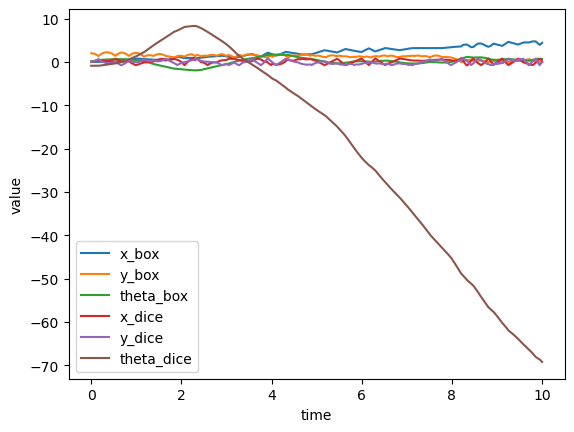

In [11]:
def simulate_impact(f, state_0, tspan, dt, integrate):
    """
    Parameters
    ============
    f: Python function
        derivate of the system at a given step x(t),
        it can considered as \dot{x}(t) = func(x(t))
    x0: NumPy array
        initial conditions
    tspan: Python list
        tspan = [min_time, max_time], it defines the start and end
        time of simulation
    dt:
        time step for numerical integration
    integrate: Python function
        numerical integration method used in this simulation

    Return
    ============
    x_traj:
        simulated trajectory of x(t) from t=0 to tf
    """
    N = int((max(tspan)-min(tspan))/dt)
    x = np.copy(state_0)
    tvec = np.linspace(min(tspan),max(tspan),N)
    xtraj = np.zeros((len(state_0),N))

    corner_p_b_dict = {}
    phi_0_system_pairs :list[tuple[float,ImpactSystem ,str]] = []
    for name,system in name_system_dict.items():
        phi_0 = system.get_phi_value(state_0)
        phi_0_system_pairs.append( (phi_0 , system , name) )
        # corner_p_b_dict[name] = []

    for i in range(N):

        for phi_0, system ,name in phi_0_system_pairs:
            # corner_p_b_dict[name].append(system.p_b.subs  )
            if system.check_for_impact(x, phi_0):
                x = np.array(system.impact_update_fun(x))
                break
                # print(f"new x {x}")
        xtraj[:,i]=integrate(f,x,dt)
        x = np.copy(xtraj[:,i])
        if (i/ N) *10 %1 == 0:
            print(f"progress: {i/N} finished")
    return tvec , xtraj


init_ang = 0.3
dice_offset_ang = -0.6
init_q = [0, 2,0.1,   0, 0, -init_ang + dice_offset_ang]
init_q_dot = [0, 0 , 2,  1, 1 ,0 ]

t_span = [0,10]
dt = 0.005
tvec , traj = simulate_impact(dyn_system_eq , init_q + init_q_dot , t_span, dt,integrate)

plt.figure(1)
plt.plot(tvec , traj[0] , label = "x_box")
plt.plot(tvec , traj[1] , label = "y_box")
plt.plot(tvec , traj[2] , label = "theta_box")
plt.plot(tvec , traj[3] , label = "x_dice")
plt.plot(tvec , traj[4] , label = "y_dice")
plt.plot(tvec , traj[5] , label = "theta_dice")
plt.xlabel("time")
plt.ylabel("value")
plt.legend()
plt.plot()




In [12]:
sym_trans_dict = { "Tsb": Tsb , "Tsd": Tsd}


trans_lambdas = lambdify_sys([*q,*q_dot] , sym_trans_dict )

get_dice_pd_dict = {}
for name,p_d in corner_P_d_map.items():
    get_dice_pd_dict[name] =sym.lambdify([*q,*q_dot], p_d )

get_box_pb_dict = {}
for name,p_b in box_corner_P_b_map.items():
    get_box_pb_dict[name] =sym.lambdify([*q,*q_dot], p_b )

In [ ]:


def animate_boxes(state_array,box_width , dice_width , T , time_sretch_ratio):
    """
    Function to generate web-based animation of double-pendulum system

    Parameters:
    ================================================
    theta_array:
        trajectory of x y t1 t2, should be a NumPy array with
        shape of (4,N)
    L:
        length of leg
    W:
        width of leg
    T:
        length/seconds of animation duration

    Returns: None
    """

    ################################
    # Imports required for animation.
    from plotly.offline import init_notebook_mode, iplot
    import plotly.graph_objects as go
    ####################################
    # Using these to specify axis limits.
    view_size = 2
    y_offset = 2
    xm = -view_size-1 #np.min(xx1)-0.5
    xM = view_size+1 #np.max(xx1)+0.5
    ym = -view_size+y_offset #np.min(yy1)-2.5
    yM = view_size+y_offset #np.max(yy1)+1.5
    T = T* time_sretch_ratio
    print(f"Animate duration {T}")
    layout=dict(autosize=False, width=1000, height=1000,
                xaxis=dict(range=[xm, xM], autorange=False, zeroline=False,dtick=1),
                yaxis=dict(range=[ym, yM], autorange=False, zeroline=False,scaleanchor = "x",dtick=1),
                title='Dice box Simulation',
                hovermode='closest',
                updatemenus= [{'type': 'buttons',
                                'buttons': [{'label': 'Play','method': 'animate',
                                            'args': [None, {'frame': {'duration': T, 'redraw': False}}]},
                                            {'args': [[None], {'frame': {'duration': T, 'redraw': False}, 'mode': 'immediate',
                                            'transition': {'duration': 0}}],'label': 'Pause','method': 'animate'}
                                            ]
                                }]
                )


    # N = len(state_array[0]) # Need this for specifying length of simulation
    def gen_transform_frame_axis_datas(T , frame_size = 0.15 , name=None):
        frame_x , frame_y = get_x_y(T)
        px = np.array([frame_size,0,0,1])
        py = np.array([0,frame_size,0,1])
        x_tip = T@px.T
        y_tip = T@py.T
        return [
            go.Scatter(name=name,
                       x=[frame_x, x_tip[0]],
                       y=[frame_y, x_tip[1]],
                       mode='lines',
                       line=dict(color='green', width=3)),
            go.Scatter(name=name,
                       x=[frame_x, y_tip[0]],
                       y=[frame_y, y_tip[1]],
                       mode='lines',
                       line=dict(color='red', width=3))
        ]

    def gen_rect_from_transform(T,L,W , color='green' , name=None):
        corners = [
            np.array([-W/2 , L/2 , 0 , 1]),
            np.array([-W/2 , -L/2 , 0 , 1]),
            np.array([W/2 , -L/2 , 0 , 1]),
            np.array([W/2 , L/2 , 0 , 1]),
        ]
        poses = []
        for c in corners:
            c_pos = T@c.T
            poses.append(c_pos)
        last_pos = poses[-1]
        output = []
        for p in poses:
            output.append(
                go.Scatter(name=name,
                           x=[last_pos[0], p[0]],
                           y=[last_pos[1], p[1]],
                           mode='lines',
                           line=dict(color=color, width=3)))
            last_pos = p
        return output
    def draw_point_from_tf(T,p , name = None):

        pos = T @ np.array(p)
        # print(pos)
        return go.Scatter(name=name,
                   x=[pos[0]],
                   y=[pos[1]],
                   mode="markers",
                   marker=dict(size=10)),

    frames=[]
    # Starting to generate each frame of simulation
    for state in state_array.T:
        frame_datas = []

        Tsb_num = trans_lambdas["Tsb"](*state)
        Tsd_num = trans_lambdas["Tsd"](*state)
        frame_datas.append(
            go.Scatter(x=[-3,3],
                y=[0,0],
                mode='lines',
                line=dict(color='green', width=3)
                ,name="Ground"
                ),
        )

        frame_datas.extend(gen_transform_frame_axis_datas(Tsb_num, name="Tsb_frame"))
        frame_datas.extend(gen_transform_frame_axis_datas(Tsd_num, name="Tsd_frame"))
        frame_datas.extend(gen_rect_from_transform(Tsb_num,box_width ,box_width,color="blue" , name="box"))
        frame_datas.extend(gen_rect_from_transform(Tsd_num,dice_width ,dice_width,color="red" , name="dice"))

        for name,func in get_dice_pd_dict.items():
            p_d = func(*state)
            frame_datas.extend(draw_point_from_tf(Tsd_num , p_d , name))

        for name,func in get_box_pb_dict.items():
            p_b = func(*state)
            frame_datas.extend(draw_point_from_tf(Tsb_num , p_b , name))

        # Generate the frame object and save it.
        frames.append(go.Frame(data=frame_datas))


    figure1=go.Figure(data=frames[0].data, layout=layout, frames=frames)
    figure1.write_html("project_animation.html")
    iplot(figure1)

animate_boxes(traj , box_width , dice_width , t_span[1],1 )